In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point
from datetime import datetime
from datetime import timedelta
from scipy.stats import linregress

In [2]:
### load COVID-19 cases data from git repository by John Hopkins University 
# https://github.com/CSSEGISandData/COVID-19

path = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
data = pd.read_csv(path).iloc[:,1:] # delete province/state level
geometry = [Point(xy) for xy in zip(data.Long, data.Lat)]
crs = {'init': 'epsg:4326'}  # inital projection of data
data_gpd = GeoDataFrame(data, crs=crs, geometry=geometry)
del data_gpd['Lat']; del data_gpd['Long']
data_gpd.rename(columns={'Country/Region': 'country'}, inplace=True)
# aggregate admin 2 data to admin 1 level
print(data_gpd.shape)
#data_gpd=data_gpd.groupby('country').sum().reset_index()
data_gpd=data_gpd.dissolve(by='country', aggfunc='sum').reset_index()
print(data_gpd.shape)
data_gpd[:5]

(264, 91)
(185, 91)


,country,geometry,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,...,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20
0,Afghanistan,POINT (65 33),0,0,0,0,0,0,0,0,...,521,555,607,665,714,784,840,906,933,996
1,Albania,POINT (20.1683 41.1533),0,0,0,0,0,0,0,0,...,416,433,446,467,475,494,518,539,548,562
2,Algeria,POINT (1.6596 28.0339),0,0,0,0,0,0,0,0,...,1761,1825,1914,1983,2070,2160,2268,2418,2534,2629
3,Andorra,POINT (1.5218 42.5063),0,0,0,0,0,0,0,0,...,601,601,638,646,659,673,673,696,704,713
4,Angola,POINT (17.8739 -11.2027),0,0,0,0,0,0,0,0,...,19,19,19,19,19,19,19,19,24,24


In [3]:
### load COVID-19 deaths data from git repository by John Hopkins University 
# https://github.com/CSSEGISandData/COVID-19

path = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
death = pd.read_csv(path).iloc[:,1:] # delete province/state level
geometry = [Point(xy) for xy in zip(death.Long, death.Lat)]
crs = {'init': 'epsg:4326'}  # inital projection of data
death_gpd = GeoDataFrame(death, crs=crs, geometry=geometry)
del death_gpd['Lat']; del death_gpd['Long']
death_gpd.rename(columns={'Country/Region': 'country'}, inplace=True)
# aggregate admin 2 data to admin 1 level
print(death_gpd.shape)
death_gpd=death_gpd.dissolve(by='country', aggfunc='sum').reset_index()
print(death_gpd.shape)
death_gpd[:5]

(264, 91)
(185, 91)


,country,geometry,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,...,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20
0,Afghanistan,POINT (65 33),0,0,0,0,0,0,0,0,...,15,18,18,21,23,25,30,30,30,33
1,Albania,POINT (20.1683 41.1533),0,0,0,0,0,0,0,0,...,23,23,23,23,24,25,26,26,26,26
2,Algeria,POINT (1.6596 28.0339),0,0,0,0,0,0,0,0,...,256,275,293,313,326,336,348,364,367,375
3,Andorra,POINT (1.5218 42.5063),0,0,0,0,0,0,0,0,...,26,26,29,29,31,33,33,35,35,36
4,Angola,POINT (17.8739 -11.2027),0,0,0,0,0,0,0,0,...,2,2,2,2,2,2,2,2,2,2


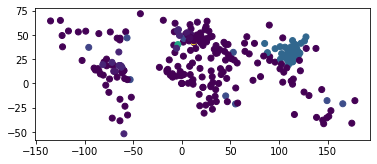

In [4]:
death_gpd.plot(column='3/28/20')

In [5]:
### load COVID-19 recovered data from git repository by John Hopkins University 
# https://github.com/CSSEGISandData/COVID-19

path = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
rec = pd.read_csv(path).iloc[:,1:] # delete province/state level
geometry = [Point(xy) for xy in zip(rec.Long, rec.Lat)]
crs = {'init': 'epsg:4326'}  # inital projection of data
rec_gpd = GeoDataFrame(rec, crs=crs, geometry=geometry)
del rec_gpd['Lat']; del rec_gpd['Long']
rec_gpd.rename(columns={'Country/Region': 'country'}, inplace=True)
# aggregate admin 2 data to admin 1 level
print(rec_gpd.shape)
rec_gpd=rec_gpd.dissolve(by='country', aggfunc='sum').reset_index()
print(rec_gpd.shape)
rec_gpd[:5]

(250, 91)
(185, 91)


,country,geometry,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,...,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20
0,Afghanistan,POINT (65 33),0,0,0,0,0,0,0,0,...,32,32,32,32,40,43,54,99,112,131
1,Albania,POINT (20.1683 41.1533),0,0,0,0,0,0,0,0,...,182,197,217,232,248,251,277,283,302,314
2,Algeria,POINT (1.6596 28.0339),0,0,0,0,0,0,0,0,...,405,460,591,601,691,708,783,846,894,1047
3,Andorra,POINT (1.5218 42.5063),0,0,0,0,0,0,0,0,...,71,71,128,128,128,169,169,191,205,235
4,Angola,POINT (17.8739 -11.2027),0,0,0,0,0,0,0,0,...,2,4,4,4,5,5,5,5,6,6


In [6]:
def doubling_time(sub_sample, inc, datatype):
    el=0
    slope_ls=[]
    while el+inc < len(sub_sample):

        s,i,r,p,std = linregress(sub_sample.index[el:el+inc], np.log2(sub_sample[datatype][el:el+inc]))
        #print (el, s, 1/s)
        if 1/s <= 0:
            s=np.nan
        slope_ls.append(1/s)
        el=el+1
    return slope_ls
        #plt.plot(xx[:el+inc],xx[:el+inc]*s+i)

def plot_cty(ctyls, datatypels, inc, case_th, death_th, opath, save=False):
    colorls=['b','r']
    # make figure + axes
    fig, axs = plt.subplots(len(ctyls),len(datatypels)+1,figsize=(5*(len(datatypels)+1),5*len(ctyls)),tight_layout=True)
    for ctyno, cty in enumerate(ctyls):
        for datano, datatype,color in zip(range(len(datatypels)),datatypels,colorls):
            if datatype=='cases':
                sample_all=data_gpd[data_gpd['country'].str.contains(cty)==True].iloc[:,2:].T  # cases
                sample_rec=rec_gpd[rec_gpd['country'].str.contains(cty)==True].iloc[:,2:].T  # recovered
                sample=sample_all - sample_rec
                sample_rec.index=pd.to_datetime(sample_rec.index)
                sample_rec.columns=['recovered']
                sample_all.index=pd.to_datetime(sample_all.index)
                sample_all.columns=['total']   
                low_th=case_th
            elif datatype=='deaths':
                sample=death_gpd[death_gpd['country'].str.contains(cty)==True].iloc[:,2:].T
                low_th=death_th
                #datano=datano+1
            else:
                print('{0} not defined. Aborted!'.format(datatype))
                break
            sample.index=pd.to_datetime(sample.index)
            sample.columns=[datatype]
            # first and third  column plot
            axs[ctyno,2*datano].set_xlabel('time')
            axs[ctyno,2*datano].set_title(cty)
            sub_sample=sample[sample[datatype] > low_th]
            axs[ctyno,2*datano].set_ylabel('{0} > {1}'.format(datatype, low_th))
            axs[ctyno,2*datano].set_xlim([sub_sample.index[0]- timedelta(days=1),sub_sample.index[-1]+ timedelta(days=1)])
            if datatype == 'deaths':
                axs[ctyno,2*datano].bar(sub_sample.index, sub_sample.iloc[:,0], color=color)
            elif datatype == 'cases':
                #axs[ctyno,2*datano].plot(sub_sample.index, np.log10(sub_sample.iloc[:,0]),'o-', color=color)
                axs[ctyno,2*datano].plot(sub_sample.index, sub_sample.iloc[:,0],'o-', color=color, label=datatype)
                sample.columns=[datatype]
                sub_sample_rec=sample_rec[sample_rec['recovered'] > low_th]
                axs[ctyno,2*datano].plot(sub_sample_rec.index, sub_sample_rec.iloc[:,0],'o-', color='g', label='recovered')
                sub_sample_all=sample_all[sample_all['total'] > low_th]
                axs[ctyno,2*datano].plot(sub_sample_all.index, sub_sample_all.iloc[:,0],'o-', color='k', label='total')
                
                #axs[ctyno,2*datano].set_yscale('log')
            [lab.set_rotation(40) for lab in axs[ctyno,2*datano].get_xticklabels()]

            # second column plot, doubling time of cases and deaths
            axs[ctyno,1].set_xlabel('time')
            axs[ctyno,1].set_ylabel('last {0} days-estimated doubling time in days'.format(inc))
            #axs[ctyno,1].set_ylim([1.8,21])
            axs[ctyno,1].set_title(cty)
            sub_sample=sub_sample.reset_index()
            xx=sub_sample.index
            axs[ctyno,1].plot(sub_sample['index'][inc:],doubling_time(sub_sample=sub_sample, inc=inc, datatype=datatype),'-o', color=color, label='based on {0} > {1}'.format(datatype, low_th))
            [lab.set_rotation(40) for lab in axs[ctyno,1].get_xticklabels()]

            print ('total {0}: {1} since '.format(datatype,sample.iloc[-1,0]), sample.index[0])
        print ('last update {0}'.format(sample.index[-1]))
        axs[ctyno,1].legend()
        axs[ctyno,0].legend()
    if save==True:
        plt.savefig(opath)
    #print (sample)

/kp/kpbkp/tgeiger/apps/miniconda3/envs/env_climada/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


total cases: 57184 since  2020-01-22 00:00:00
total deaths: 4586 since  2020-01-22 00:00:00
last update 2020-04-19 00:00:00
total cases: 688749 since  2020-01-22 00:00:00
total deaths: 40661 since  2020-01-22 00:00:00
last update 2020-04-19 00:00:00
total cases: 131917 since  2020-01-22 00:00:00
total deaths: 23660 since  2020-01-22 00:00:00
last update 2020-04-19 00:00:00
total cases: 121317 since  2020-01-22 00:00:00
total deaths: 20453 since  2020-01-22 00:00:00
last update 2020-04-19 00:00:00
total cases: 116914 since  2020-01-22 00:00:00
total deaths: 19744 since  2020-01-22 00:00:00
last update 2020-04-19 00:00:00
total cases: 120736 since  2020-01-22 00:00:00
total deaths: 16095 since  2020-01-22 00:00:00
last update 2020-04-19 00:00:00
total cases: 13835 since  2020-01-22 00:00:00
total deaths: 1540 since  2020-01-22 00:00:00
last update 2020-04-19 00:00:00
total cases: 2255 since  2020-01-22 00:00:00
total deaths: 54 since  2020-01-22 00:00:00
last update 2020-04-19 00:00:00


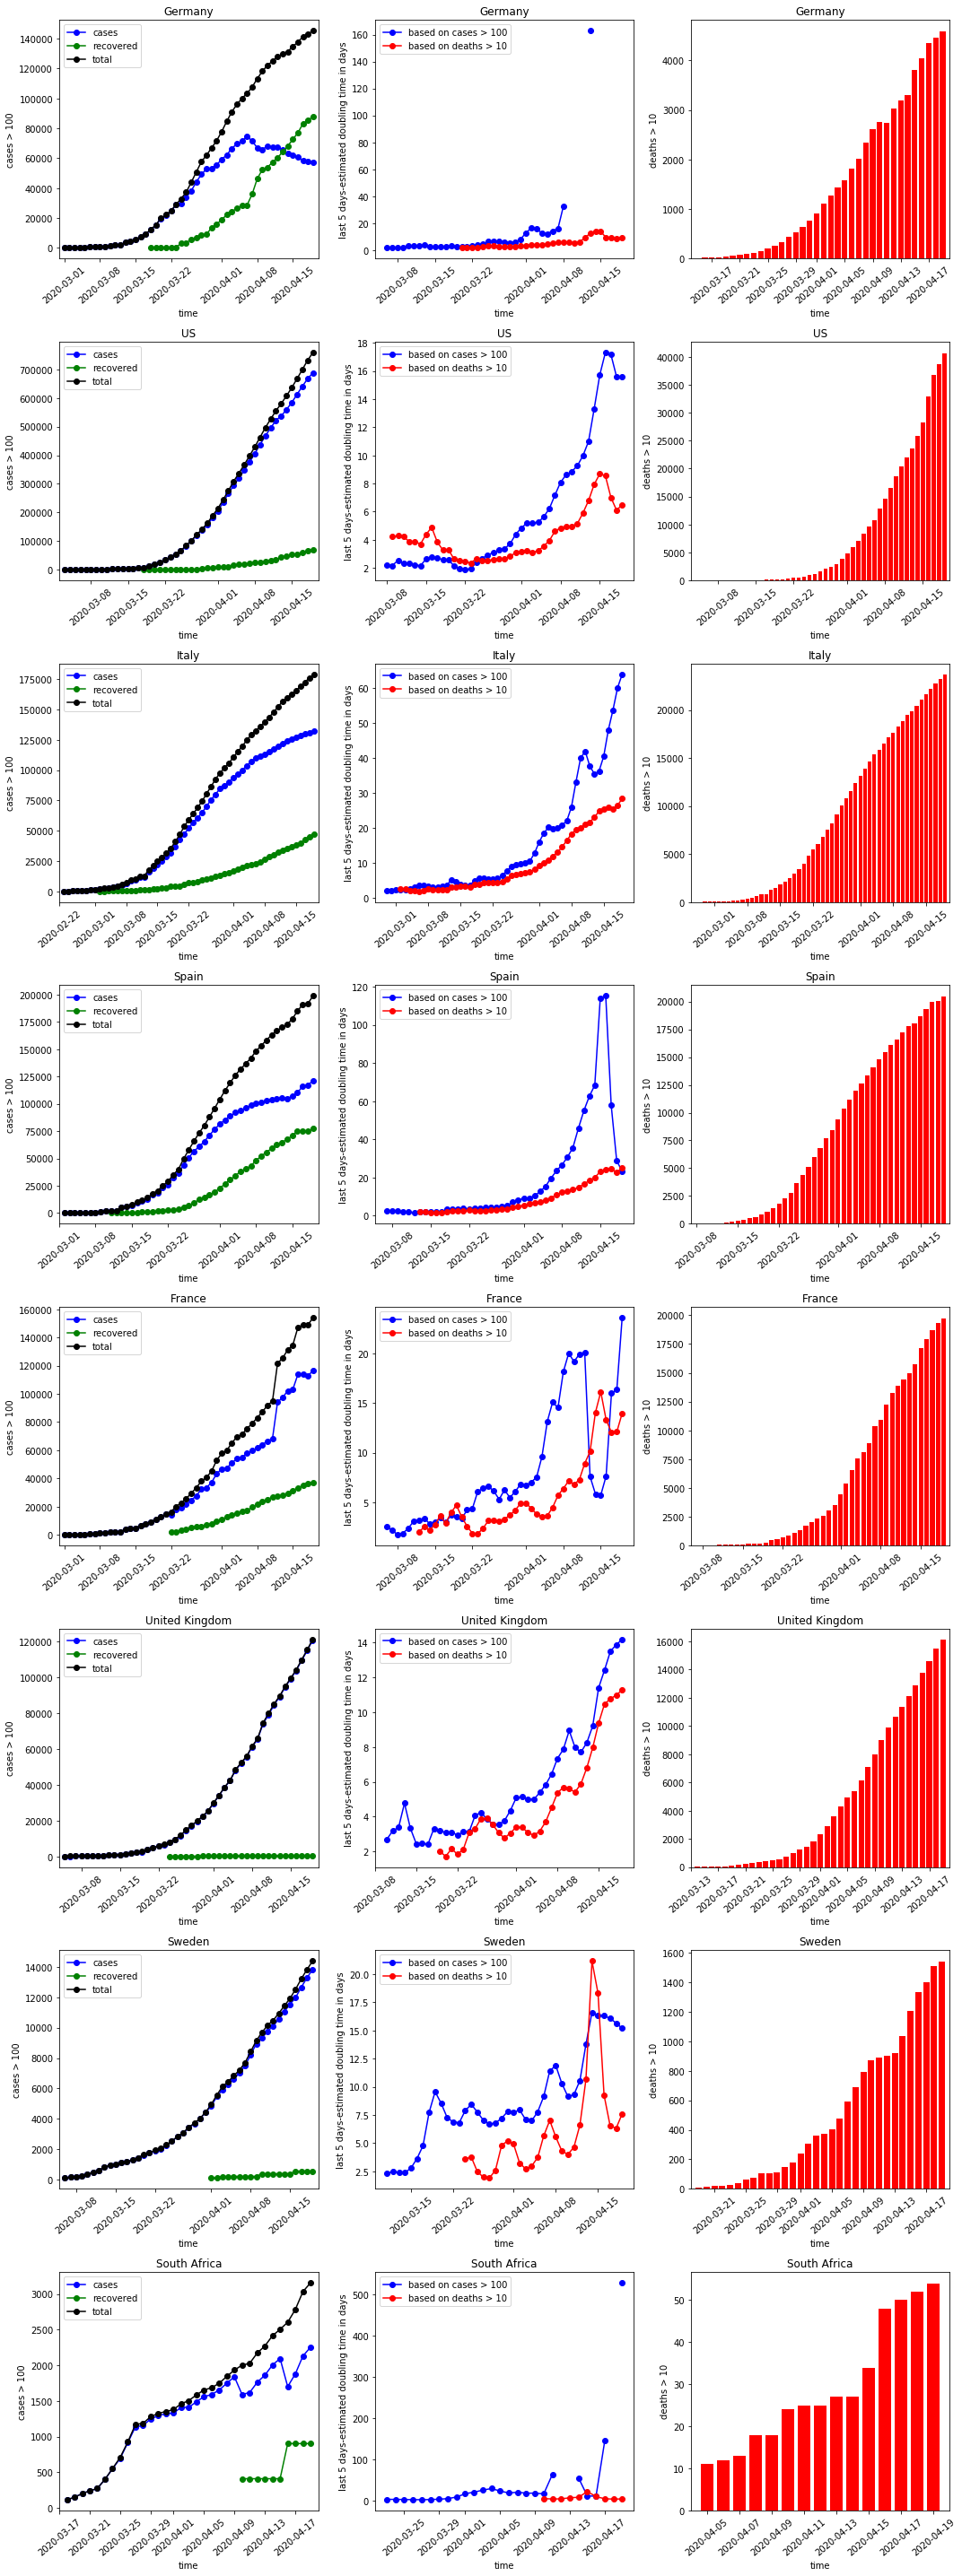

In [7]:
### plot country data
# choose country
ctyls=['Germany','US','Italy','Spain', 'France','United Kingdom','Sweden','South Africa']
#ctyls=['China','Korea','Germany']
datatypels=['cases','deaths']
opath='COVID-19_doubling-time_analysis_by_country.pdf'
plot_cty(ctyls = ctyls, datatypels = datatypels, inc=5, case_th=100, death_th=10, opath=opath, save=True)


0 0.4845235429539928 2.0638831993659252 0.069461256368466
1 0.5754468737860691 1.7377798812610543 0.05679883958409294
2 0.5643075959831801 1.77208318143888 0.061808737172987564
3 0.4854322544684463 2.0600196851258086 0.07121834853001008
4 0.3272707086061102 3.0555744027906866 0.028071946500754206
5 0.28480641902349896 3.5111568181245643 0.015550541691869268
6 0.3032948488747176 3.2971216085937263 0.019592650456191865
7 0.27140746089669554 3.684497090448906 0.023753159045697518
8 0.38085406423485024 2.625677638517621 0.05870811515517336
9 0.42611548492602974 2.346781648110235 0.056257512505522286
10 0.4365196922427842 2.290847395365198 0.054270150425872535
11 0.4286268579841185 2.333031590001418 0.05642725199441968
12 0.33476095515183407 2.987206197767121 0.002615415251042058
13 0.3534821816261195 2.8289969112437663 0.009208259611374175
14 0.35691153184191915 2.8018147658028414 0.008384483406695177
15 0.3624158652651245 2.7592611026243357 0.007266011577101925
16 0.3202479113453963 3.122

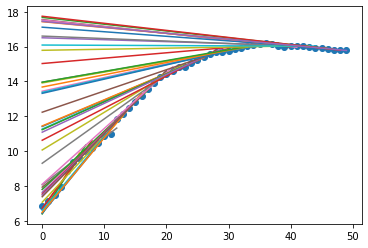

In [8]:
cty='Germany'; datatype='cases'
#sample=data_gpd[data_gpd['country'].str.contains(cty)==True].iloc[:,2:].T
sample_all=data_gpd[data_gpd['country'].str.contains(cty)==True].iloc[:,2:].T  # cases
sample_rec=rec_gpd[rec_gpd['country'].str.contains(cty)==True].iloc[:,2:].T  # recovered
sample=sample_all - sample_rec
sample.index=pd.to_datetime(sample.index)
sample.columns=[datatype]
sub_sample=sample[sample[datatype] > 100]
sub_sample=sub_sample.reset_index()
xx=sub_sample.index
plt.scatter(xx, np.log2(sub_sample[datatype]))
el=0
inc=5
while el+inc < len(sub_sample):
    
    s,i,r,p,std = linregress(xx[el:el+inc], np.log2(sub_sample[datatype][el:el+inc]))
    print (el, s, 1/s, std)
    el=el+1
    plt.plot(xx[:el+inc],xx[:el+inc]*s+i)